In [1]:
# # Install necessary packages
# !pip install --upgrade google-cloud-bigquery
# !pip install torch_geometric
# !pip install google-cloud-bigquery-storage==2.18.1
# !pip install --upgrade google-cloud-bigquery[pandas]


In [2]:
# Mount Google Drive to access the utils_fuc.py script
from google.colab import drive
drive.mount('/content/drive')

# Add the lib folder to the Python path
import sys
sys.path.append('/content/drive/My Drive/Expt_GNNs_MIMIC-iii')

# Import the functions from utils_fuc.py
from lib.utils_fuc import (
    authenticate_and_create_client, fetch_data, preprocess_data, construct_graph, plot_graph,
    prepare_data_for_gcn, GCN, train_model, evaluate_model, plot_confusion_matrix
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set parameters
project_id = 'forward-citron-385513'
subject_ids = [2, 4, 5, 3, 9, 11]  # Can be a single ID or a list of IDs
epochs = 100
learning_rate = 0.01

In [4]:
# Authenticate and create BigQuery client
client = authenticate_and_create_client(project_id)
client

In [5]:
# Load data
df = fetch_data(client, subject_ids)
df.head()

,subject_id,gender,dob,dod,expire_flag,hadm_id,admittime,dischtime,deathtime,admission_type,...,icu_outtime,icu_los,diagnosis_icd9_code,diagnosis_long_title,lab_itemid,lab_charttime,lab_value,lab_valuenum,lab_valueuom,lab_item_label
0,2,M,2138-07-17,NaT,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,...,2138-07-17 23:32:21,0.0918,V3001,"Single liveborn, born in hospital, delivered b...",51222,2138-07-17 20:48:00,0,0.0,g/dL,Hemoglobin
1,2,M,2138-07-17,NaT,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,...,2138-07-17 23:32:21,0.0918,V3001,"Single liveborn, born in hospital, delivered b...",51221,2138-07-17 20:48:00,0,0.0,%,Hematocrit
2,2,M,2138-07-17,NaT,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,...,2138-07-17 23:32:21,0.0918,V3001,"Single liveborn, born in hospital, delivered b...",51251,2138-07-17 20:48:00,0,0.0,%,Metamyelocytes
3,2,M,2138-07-17,NaT,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,...,2138-07-17 23:32:21,0.0918,V3001,"Single liveborn, born in hospital, delivered b...",51265,2138-07-17 20:48:00,5,5.0,K/uL,Platelet Count
4,2,M,2138-07-17,NaT,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,...,2138-07-17 23:32:21,0.0918,V3001,"Single liveborn, born in hospital, delivered b...",51301,2138-07-17 20:48:00,0.1,0.1,K/uL,White Blood Cells


In [6]:
# Preprocess data
df = preprocess_data(df)
df.head()

/content/drive/My Drive/Expt_GNNs_MIMIC-iii/lib/utils_fuc.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[us], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


,subject_id,gender,dob,dod,expire_flag,hadm_id,admittime,dischtime,deathtime,admission_type,...,icu_outtime,icu_los,diagnosis_icd9_code,diagnosis_long_title,lab_itemid,lab_charttime,lab_value,lab_valuenum,lab_valueuom,lab_item_label
0,2,1,2138-07-17,0,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,0,1,...,2138-07-17 23:32:21,0.0918,26,"Single liveborn, born in hospital, delivered b...",101,2138-07-17 20:48:00,0,0.0,g/dL,Hemoglobin
1,2,1,2138-07-17,0,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,0,1,...,2138-07-17 23:32:21,0.0918,26,"Single liveborn, born in hospital, delivered b...",100,2138-07-17 20:48:00,0,0.0,%,Hematocrit
2,2,1,2138-07-17,0,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,0,1,...,2138-07-17 23:32:21,0.0918,26,"Single liveborn, born in hospital, delivered b...",109,2138-07-17 20:48:00,0,0.0,%,Metamyelocytes
3,2,1,2138-07-17,0,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,0,1,...,2138-07-17 23:32:21,0.0918,26,"Single liveborn, born in hospital, delivered b...",116,2138-07-17 20:48:00,5,5.0,K/uL,Platelet Count
4,2,1,2138-07-17,0,0,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,0,1,...,2138-07-17 23:32:21,0.0918,26,"Single liveborn, born in hospital, delivered b...",126,2138-07-17 20:48:00,0.1,0.1,K/uL,White Blood Cells


In [7]:
# Construct graph
G = construct_graph(df)
G

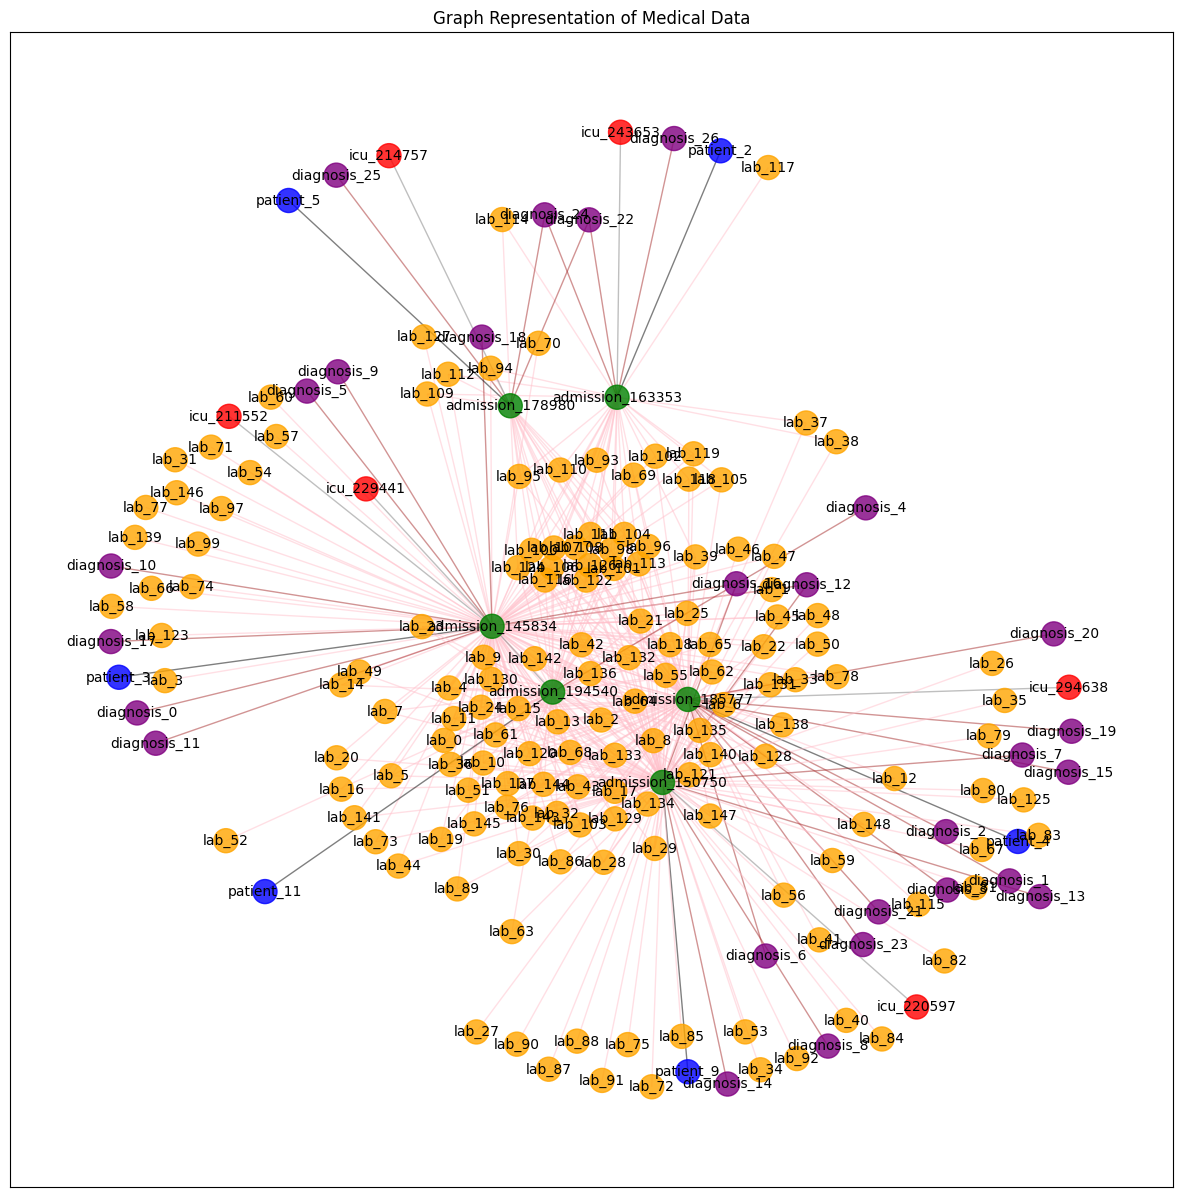

In [8]:
# Plot graph
plot_graph(G)

In [9]:
# Prepare data for GCN
data = prepare_data_for_gcn(G, df)
data

Data(x=[15103, 22], edge_index=[2, 924], y=[15103])

In [10]:
import torch

# Split data into train, validation, and test sets
train_mask = torch.rand(data.num_nodes) < 0.8
val_mask = (torch.rand(data.num_nodes) >= 0.8) & (torch.rand(data.num_nodes) < 0.9)
test_mask = torch.rand(data.num_nodes) >= 0.9
train_mask, val_mask, test_mask

(tensor([ True,  True,  True,  ..., False,  True, False]),
 tensor([False,  True, False,  ...,  True, False, False]),
 tensor([ True, False, False,  ..., False, False,  True]))

In [11]:
# Define and train the GCN model
num_classes = len(df['expire_flag'].unique())
model = GCN(data.num_features, num_classes)
model

GCN(
  (conv1): GCNConv(22, 16)
  (conv2): GCNConv(16, 2)
)

In [18]:
# Train the model
train_model(model, data, train_mask, val_mask, epochs=epochs, lr=learning_rate)

Epoch 0, Loss: 35098193821696.0, Validation Loss: 34384111468544.0
Epoch 10, Loss: 107863909335040.0, Validation Loss: 108933951782912.0
Epoch 20, Loss: 14790455984128.0, Validation Loss: 14541742145536.0
Epoch 30, Loss: 8035551936512.0, Validation Loss: 8137846816768.0
Epoch 40, Loss: 1104969465856.0, Validation Loss: 1143682105344.0
Epoch 50, Loss: 20603496448.0, Validation Loss: 59398959104.0
Epoch 60, Loss: 19894239232.0, Validation Loss: 57681887232.0
Epoch 70, Loss: 12985668993024.0, Validation Loss: 12778668556288.0
Epoch 80, Loss: 17639334215680.0, Validation Loss: 17842927828992.0
Epoch 90, Loss: 3393937211392.0, Validation Loss: 3455591120896.0


In [19]:
# Evaluate the model
accuracy, preds, true_labels = evaluate_model(model, data, test_mask)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8633045554161072


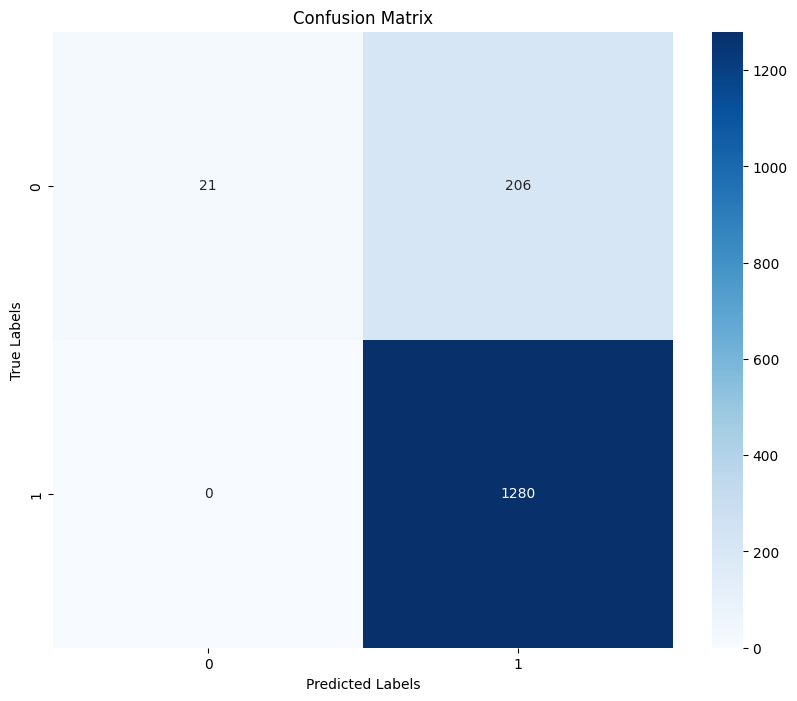

In [20]:
# Plot confusion matrix
plot_confusion_matrix(true_labels.cpu().numpy(), preds.cpu().numpy())